In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import statsmodels.api as sm 

pd.set_option('display.max_columns',None)

import warnings
warnings.filterwarnings('ignore')

from statistics import mode

In [3]:
# import the subset data with 10,000 users transactions
df = pd.read_csv('data/sample.csv')
df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_weekend
0,8,23423,1,1,Original Hawaiian Sweet Rolls,43,3,buns rolls,bakery,3107,prior,5,4,6,17.0,0.0
1,40,10070,1,1,Organic 1% Low Fat Milk,84,16,milk,dairy eggs,382,prior,29,1,15,23.0,0.0
2,40,42450,2,1,Macaroni & Cheese,38,1,frozen meals,frozen,382,prior,29,1,15,23.0,0.0
3,40,33198,3,1,Sparkling Natural Mineral Water,115,7,water seltzer sparkling water,beverages,382,prior,29,1,15,23.0,0.0
4,40,34866,4,1,Chocolate Milk 1% Milkfat,84,16,milk,dairy eggs,382,prior,29,1,15,23.0,0.0


In [6]:
#sanity check 
display(df.shape)

print(f'Number of unique users: {len(df["user_id"].unique())}')

(1544933, 16)

Number of unique users: 10000


In [8]:
# Check the reordered ratio in the df
print('Reorder ratio in the sample:')
df['reordered'].value_counts(normalize=True)

Reorder ratio in the sample:


1    0.591075
0    0.408925
Name: reordered, dtype: float64

The reordered ratio from the sample is relatively similar to the reordered ratio in the orders_prior data with 200K users. 

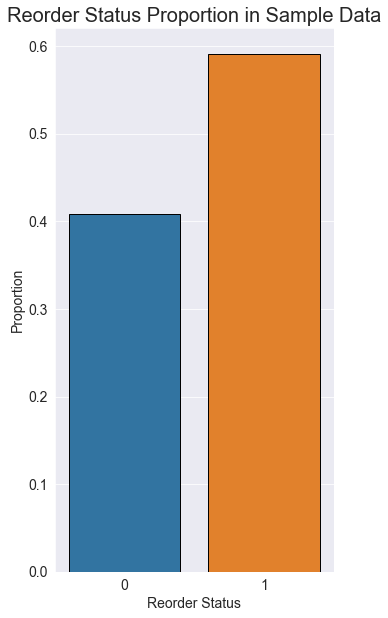

In [29]:
#plot the reordered ratio 

sns.set_style('darkgrid')
plt.figure(figsize=(5,10))
sns.barplot(df['reordered'].value_counts().index, df['reordered'].value_counts(normalize=True).values, edgecolor='black')
plt.xlabel('Reorder Status', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14,)
plt.title('Reorder Status Proportion in Sample Data', fontsize=20)
plt.show()


#### User & Product Specific Profile

In [30]:
#### user and product specific profile

'''
1. calculate how many times each product is order by each users
2. calculate total number of orders for each user
3. Calculate reorderd ratio for each product related to each users. This ratio demonstrate 
4. Calculate mode order_dow for each product related to the user
5. Calculate mode order_hour_of_day for each product related to the user
6. Calculate the overall reorder_ratio for each product
'''

#1. count how many times each product ordered by user

user_product_reorder_count = df.groupby(['user_id','product_id'])['order_id'].aggregate('count').to_frame('user_product_reorder_count').reset_index()

In [31]:
# 2.calculate total number of orders for each user
# user_orders_count is the total number of orders the user placed on instacart
user_order_count = df.groupby('user_id')['order_id'].nunique().to_frame('user_orders_count').reset_index()

#merge user_product_reorder_count and user_orders_count
user_product = pd.merge(user_product_reorder_count,user_order_count, on= 'user_id', how='left')

In [32]:
#3. calculate the reorder_ratio for each product related to each user
user_product['reorder_ratio']=user_product['user_product_reorder_count']/user_product['user_orders_count']

In [33]:
#4. Calculate mode order_dow for each product related to the user
#5. Calculate mode order_hour_of_day for each product related to the user

mod_dow = df.groupby(['user_id','product_id'])[['order_dow','order_hour_of_day']].aggregate(lambda x: stats.mode(x)[0]).reset_index()
mod_dow.columns=['user_id','product_id','p_order_dow','p_order_hour_of_day']

# merger mod_dow and user_product

user_product = user_product.merge(mod_dow,on=['user_id','product_id'],how='left')
user_product.head()

,user_id,product_id,user_product_reorder_count,user_orders_count,reorder_ratio,p_order_dow,p_order_hour_of_day
0,1,196,10,10,1.0,1,7
1,1,10258,9,10,0.9,1,7
2,1,10326,1,10,0.1,4,15
3,1,12427,10,10,1.0,1,7
4,1,13032,3,10,0.3,1,7


In [35]:
# merge user_product and df together by user_id and product_id

df1 = df.drop(['order_number','order_dow','order_hour_of_day','eval_set'], axis=1)
df1 = pd.merge(df1,user_product, on=['user_id','product_id'], how='left')

#delete unnecessary columns in df1
df1 = df1.drop(['order_id','product_name','aisle','department'],axis=1)
df1.head()

,product_id,add_to_cart_order,reordered,aisle_id,department_id,user_id,days_since_prior_order,order_weekend,user_product_reorder_count,user_orders_count,reorder_ratio,p_order_dow,p_order_hour_of_day
0,23423,1,1,43,3,3107,17.0,0.0,16,27,0.592593,1,11
1,10070,1,1,84,16,382,23.0,0.0,14,29,0.482759,1,15
2,42450,2,1,38,1,382,23.0,0.0,15,29,0.517241,1,15
3,33198,3,1,115,7,382,23.0,0.0,19,29,0.655172,1,15
4,34866,4,1,84,16,382,23.0,0.0,18,29,0.620690,1,8


#### User Specifc Profiles

In [36]:
#### User specific profiles
'''
1. calculate total product per user
2. calculate total orders per user
3. calculate avg_product order by users from step 1 and step 2
4. Calculate user reordered ratio by sum(reordered_product)/sum(total product)
5. Calculate user most frequent orders_dow by using mode of the orders_dow for each user
6. Calculate user most frequent orders_hour_of_day by using mode of the order_hour_of_day for each user


'''
# 1. calculate total product per order for each user
# total product is the sum of products for each users 
total_product = df.groupby(['user_id'])['product_id'].agg('count').to_frame('total_product').reset_index()

In [37]:
#2. calculate number of orders per user_id 
user_order_count = df.groupby('user_id')['order_id'].nunique().to_frame('user_orders_count').reset_index()

In [38]:
#3. calculate average number of products purchased by each user
user_profile = pd.merge(total_product,user_order_count,on='user_id',how='left')
user_profile['avg_pro']=user_profile['total_product']/user_profile['user_orders_count']

In [39]:
#4. Calculate user reordered ratio by sum(reordered_product)/sum(total product)
u_reorder_ratio = df.groupby(['user_id'])['reordered'].agg('mean').to_frame('u_reorder_ratio').reset_index()
user_profile = user_profile.merge(u_reorder_ratio,on='user_id',how='left')

In [40]:
#5. Calculate user most frequent orders_dow by using mode of the orders_dow for each user
#6. Calculate user most frequent orders_hour_of_day by using mode of the order_hour_of_day for each user

u_mod = df.groupby(['user_id'])[['order_dow','order_hour_of_day']].aggregate(lambda x: stats.mode(x)[0]).reset_index()
u_mod.columns=['user_id','u_order_dow','u_order_hour_of_day']


# merge all user_order_mode and user_profile together
user_profile = pd.merge(user_profile,u_mod,on='user_id', how='left')
user_profile = user_profile.drop(['total_product','user_orders_count'],axis=1)
user_profile.head()

,user_id,avg_pro,u_reorder_ratio,u_order_dow,u_order_hour_of_day
0,1,5.900000,0.694915,4,7
1,2,13.928571,0.476923,2,9
2,3,7.333333,0.625000,0,16
3,4,3.600000,0.055556,4,15
4,5,9.250000,0.378378,3,18


In [41]:
#merge user specific information with df1

df1 = df1.merge(user_profile,on='user_id',how='left')
df1.head()

,product_id,add_to_cart_order,reordered,aisle_id,department_id,user_id,days_since_prior_order,order_weekend,user_product_reorder_count,user_orders_count,reorder_ratio,p_order_dow,p_order_hour_of_day,avg_pro,u_reorder_ratio,u_order_dow,u_order_hour_of_day
0,23423,1,1,43,3,3107,17.0,0.0,16,27,0.592593,1,11,4.037037,0.550459,1,16
1,10070,1,1,84,16,382,23.0,0.0,14,29,0.482759,1,15,7.310345,0.617925,1,13
2,42450,2,1,38,1,382,23.0,0.0,15,29,0.517241,1,15,7.310345,0.617925,1,13
3,33198,3,1,115,7,382,23.0,0.0,19,29,0.655172,1,15,7.310345,0.617925,1,13
4,34866,4,1,84,16,382,23.0,0.0,18,29,0.620690,1,8,7.310345,0.617925,1,13


In [42]:
# drop department_id since they are similar to aisle_id
df1 = df1.drop(['department_id'],axis=1)
df1.shape

(1544933, 16)

In [34]:
# save the data for further analysis
df1.to_csv('data/df1.csv',index=False)

In [43]:
#convert aisle_id to categorical and one hot enoding

#check on whether aisle_id have been convert to string
df1['aisle_id'] = df1['aisle_id'].map(str)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1544933 entries, 0 to 1544932
Data columns (total 16 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   product_id                  1544933 non-null  int64  
 1   add_to_cart_order           1544933 non-null  int64  
 2   reordered                   1544933 non-null  int64  
 3   aisle_id                    1544933 non-null  object 
 4   user_id                     1544933 non-null  int64  
 5   days_since_prior_order      1446475 non-null  float64
 6   order_weekend               1544933 non-null  float64
 7   user_product_reorder_count  1544933 non-null  int64  
 8   user_orders_count           1544933 non-null  int64  
 9   reorder_ratio               1544933 non-null  float64
 10  p_order_dow                 1544933 non-null  int64  
 11  p_order_hour_of_day         1544933 non-null  int64  
 12  avg_pro                     1544933 non-null  float64
 1

In [44]:
# Convert aisle_id to dummy using one hot encoding
df2 = pd.get_dummies(df1)
df2.head()

,product_id,add_to_cart_order,reordered,user_id,days_since_prior_order,order_weekend,user_product_reorder_count,user_orders_count,reorder_ratio,p_order_dow,p_order_hour_of_day,avg_pro,u_reorder_ratio,u_order_dow,u_order_hour_of_day,aisle_id_1,aisle_id_10,aisle_id_100,aisle_id_101,aisle_id_102,aisle_id_103,aisle_id_104,aisle_id_105,aisle_id_106,aisle_id_107,aisle_id_108,aisle_id_109,aisle_id_11,aisle_id_110,aisle_id_111,aisle_id_112,aisle_id_113,aisle_id_114,aisle_id_115,aisle_id_116,aisle_id_117,aisle_id_118,aisle_id_119,aisle_id_12,aisle_id_120,aisle_id_121,aisle_id_122,aisle_id_123,aisle_id_124,aisle_id_125,aisle_id_126,aisle_id_127,aisle_id_128,aisle_id_129,aisle_id_13,aisle_id_130,aisle_id_131,aisle_id_132,aisle_id_133,aisle_id_134,aisle_id_14,aisle_id_15,aisle_id_16,aisle_id_17,aisle_id_18,aisle_id_19,aisle_id_2,aisle_id_20,aisle_id_21,aisle_id_22,aisle_id_23,aisle_id_24,aisle_id_25,aisle_id_26,aisle_id_27,aisle_id_28,aisle_id_29,aisle_id_3,aisle_id_30,aisle_id_31,aisle_id_32,aisle_id_33,aisle_id_34,aisle_id_35,aisle_id_36,aisle_id_37,aisle_id_38,aisle_id_39,aisle_id_4,aisle_id_40,aisle_id_41,aisle_id_42,aisle_id_43,aisle_id_44,aisle_id_45,aisle_id_46,aisle_id_47,aisle_id_48,aisle_id_49,aisle_id_5,aisle_id_50,aisle_id_51,aisle_id_52,aisle_id_53,aisle_id_54,aisle_id_55,aisle_id_56,aisle_id_57,aisle_id_58,aisle_id_59,aisle_id_6,aisle_id_60,aisle_id_61,aisle_id_62,aisle_id_63,aisle_id_64,aisle_id_65,aisle_id_66,aisle_id_67,aisle_id_68,aisle_id_69,aisle_id_7,aisle_id_70,aisle_id_71,aisle_id_72,aisle_id_73,aisle_id_74,aisle_id_75,aisle_id_76,aisle_id_77,aisle_id_78,aisle_id_79,aisle_id_8,aisle_id_80,aisle_id_81,aisle_id_82,aisle_id_83,aisle_id_84,aisle_id_85,aisle_id_86,aisle_id_87,aisle_id_88,aisle_id_89,aisle_id_9,aisle_id_90,aisle_id_91,aisle_id_92,aisle_id_93,aisle_id_94,aisle_id_95,aisle_id_96,aisle_id_97,aisle_id_98,aisle_id_99
0,23423,1,1,3107,17.0,0.0,16,27,0.592593,1,11,4.037037,0.550459,1,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,10070,1,1,382,23.0,0.0,14,29,0.482759,1,15,7.310345,0.617925,1,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,42450,2,1,382,23.0,0.0,15,29,0.517241,1,15,7.310345,0.617925,1,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,33198,3,1,382,23.0,0.0,19,29,0.655172,1,15,7.310345,0.617925,1,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,34866,4,1,382,23.0,0.0,18,29,0.620690,1,8,7.310345,0.617925,1,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
# fill in na value in days_since_prior_order with 0
df2 = df2.fillna(0)
df2['days_since_prior_order'].isnull().sum()

0

In [46]:
df2 = df2.set_index(['user_id','product_id'])
df2.head()

add_to_cart_order  reordered  days_since_prior_order  \
user_id product_id                                                         
3107    23423                       1          1                    17.0   
382     10070                       1          1                    23.0   
        42450                       2          1                    23.0   
        33198                       3          1                    23.0   
        34866                       4          1                    23.0   

                    order_weekend  user_product_reorder_count  \
user_id product_id                                              
3107    23423                 0.0                          16   
382     10070                 0.0                          14   
        42450                 0.0                          15   
        33198                 0.0                          19   
        34866                 0.0                          18   

                    user_orders_count  reorder_ratio  p_order_dow  \
user_id product_id                                                  
3107    23423                      27       0.592593            1   
382     10070                      29       0.482759            1   
        42450                      29       0.517241            1   
        33198                      29       0.655172            1   
        34866                      29       0.620690            1   

                    p_order_hour_of_day   avg_pro  u_reorder_ratio  \
user_id product_id                                                   
3107    23423                        11  4.037037         0.550459   
382     10070                        15  7.310345         0.617925   
        42450                        15  7.310345         0.617925   
        33198                        15  7.310345         0.617925   
        34866                         8  7.310345         0.617925   

                    u_order_dow  u_order_hour_of_day  aisle_id_1  aisle_id_10  \
user_id product_id                                                              
3107    23423                 1                   16           0            0   
382     10070                 1                   13           0            0   
        42450                 1                   13           0            0   
        33198                 1                   13           0            0   
        34866                 1                   13           0            0   

                    aisle_id_100  aisle_id_101  aisle_id_102  aisle_id_103  \
user_id product_id                                                           
3107    23423                  0             0             0             0   
382     10070                  0             0             0             0   
        42450                  0             0             0             0   
        33198                  0             0             0             0   
        34866                  0             0             0             0   

                    aisle_id_104  aisle_id_105  aisle_id_106  aisle_id_107  \
user_id product_id                                                           
3107    23423                  0             0             0             0   
382     10070                  0             0             0             0   
        42450                  0             0             0             0   
        33198                  0             0             0             0   
        34866                  0             0             0             0   

                    aisle_id_108  aisle_id_109  aisle_id_11  aisle_id_110  \
user_id product_id                                                          
3107    23423                  0             0            0             0   
382     10070                  0             0            0             0   
        42450                  0             0            0             0   
        3

In [46]:
# save df2 for modeling
df2.to_csv('data/df2.csv',index =True)